In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyreadstat
import numpy as np
from scipy import stats
from scipy.stats import zscore
from pathlib import Path
import os

DATA_PATH = Path('data')
sns.set_style("whitegrid")

os.makedirs('img/analysis', exist_ok=True)

In [12]:
df, metadata = pyreadstat.read_sav(DATA_PATH / 'matrimonios_unified.sav')

In [13]:
print("\n" + "="*50)
print("PREGUNTA A: Descripción del Conjunto de Datos")
print("="*50)

shape = df.shape
n_rows = df.shape[0]
n_cols = df.shape[1]
column_names = df.columns.tolist()
dtypes = df.dtypes
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category', 'str']).columns.tolist()
missing_values = df.isnull().sum()
n_duplicates = df.duplicated().sum()
memory_usage_mb = df.memory_usage(deep=True).sum() / 1024**2

print(f"\nForma: {shape}")
print(f"Filas: {n_rows:,}")
print(f"Columnas: {n_cols}")
print(f"\nVariables numéricas ({len(numerical_cols)}): {numerical_cols}")
print(f"\nVariables categóricas ({len(categorical_cols)}): {categorical_cols}")
print(f"\nTotal valores faltantes: {missing_values.sum()}")
print(f"Filas duplicadas: {n_duplicates:,}")
print(f"Uso de memoria: {memory_usage_mb:.2f} MB")

df.info()


PREGUNTA A: Descripción del Conjunto de Datos

Forma: (1055847, 15)
Filas: 1,055,847
Columnas: 15

Variables numéricas (1): ['year']

Variables categóricas (14): ['depreg', 'mesreg', 'edadhom', 'edadmuj', 'pueblo_hombre', 'pueblo_mujer', 'nupcialidad_hombre', 'nupcialidad_mujer', 'depocu', 'mesocu', 'area_geografica', 'eschom', 'escmuj', 'areagocu']

Total valores faltantes: 0
Filas duplicadas: 19,570
Uso de memoria: 797.26 MB
<class 'pandas.DataFrame'>
RangeIndex: 1055847 entries, 0 to 1055846
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   depreg              1055847 non-null  str    
 1   mesreg              1055847 non-null  str    
 2   edadhom             1055847 non-null  str    
 3   edadmuj             1055847 non-null  str    
 4   pueblo_hombre       1055847 non-null  str    
 5   pueblo_mujer        1055847 non-null  str    
 6   nupcialidad_hombre  1055847 non-null  str    
 7   nu

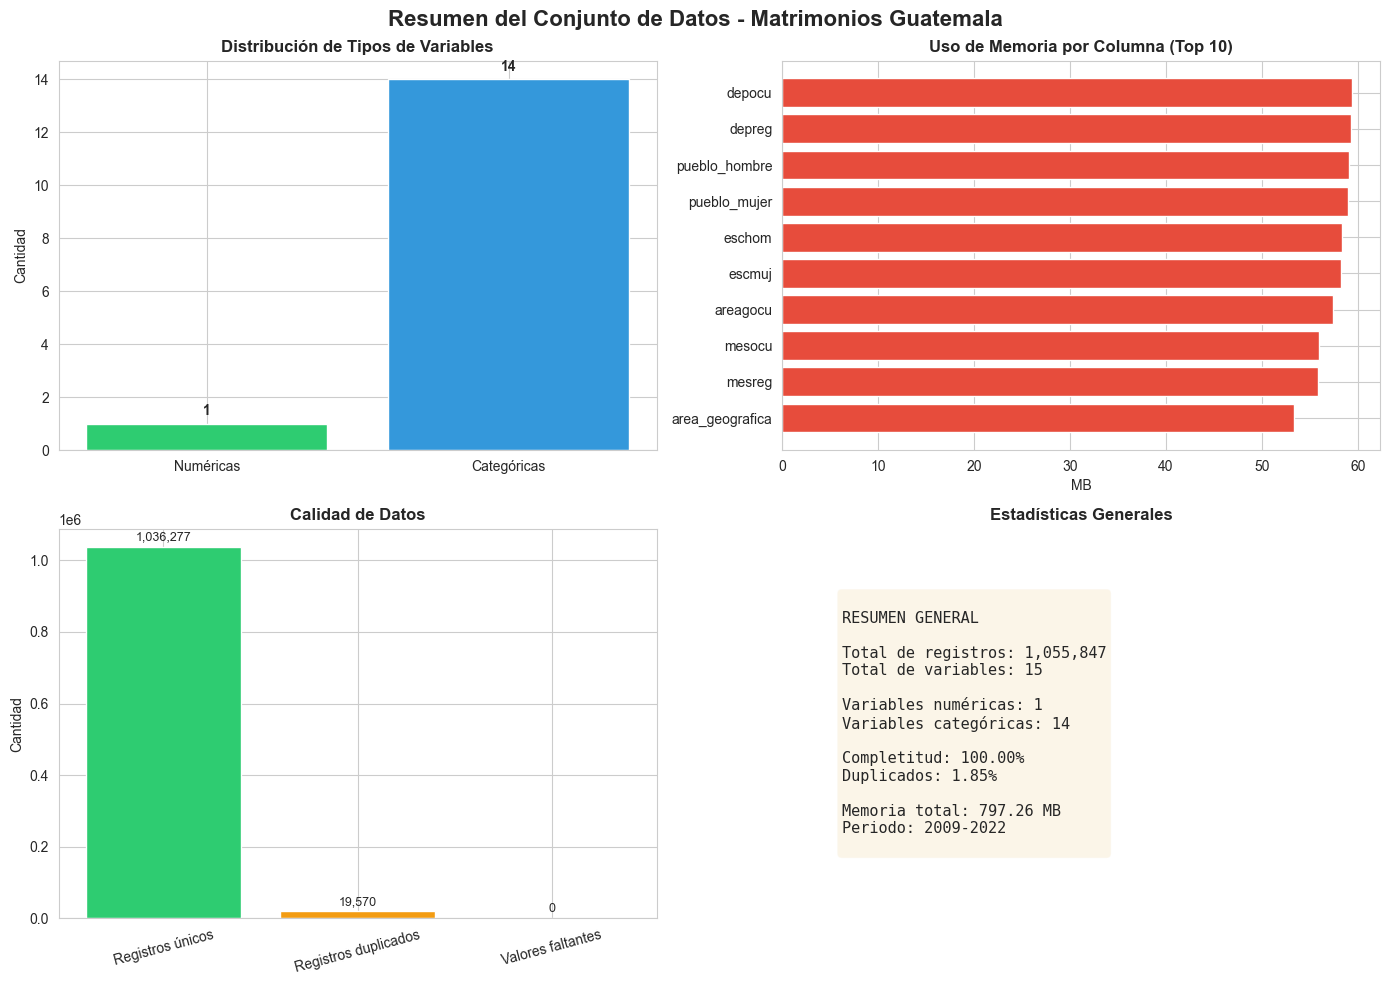

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Resumen del Conjunto de Datos - Matrimonios Guatemala', fontsize=16, fontweight='bold')

type_counts = pd.Series({
    'Numéricas': len(numerical_cols),
    'Categóricas': len(categorical_cols)
})
axes[0, 0].bar(type_counts.index, type_counts.values, color=['#2ecc71', '#3498db'])
axes[0, 0].set_title('Distribución de Tipos de Variables', fontweight='bold')
axes[0, 0].set_ylabel('Cantidad')
for i, v in enumerate(type_counts.values):
    axes[0, 0].text(i, v + 0.2, str(v), ha='center', va='bottom', fontweight='bold')

memory_by_col = df.memory_usage(deep=True) / 1024**2
memory_by_col = memory_by_col.sort_values(ascending=False).head(10)
axes[0, 1].barh(memory_by_col.index, memory_by_col.values, color='#e74c3c')
axes[0, 1].set_title('Uso de Memoria por Columna (Top 10)', fontweight='bold')
axes[0, 1].set_xlabel('MB')
axes[0, 1].invert_yaxis()

quality_data = pd.Series({
    'Registros únicos': n_rows - n_duplicates,
    'Registros duplicados': n_duplicates,
    'Valores faltantes': missing_values.sum()
})
colors = ['#2ecc71', '#f39c12', '#e74c3c']
axes[1, 0].bar(quality_data.index, quality_data.values, color=colors)
axes[1, 0].set_title('Calidad de Datos', fontweight='bold')
axes[1, 0].set_ylabel('Cantidad')
axes[1, 0].tick_params(axis='x', rotation=15)
for i, v in enumerate(quality_data.values):
    axes[1, 0].text(i, v + max(quality_data.values)*0.01, f'{v:,}', ha='center', va='bottom', fontsize=9)

summary_text = f"""
RESUMEN GENERAL

Total de registros: {n_rows:,}
Total de variables: {n_cols}

Variables numéricas: {len(numerical_cols)}
Variables categóricas: {len(categorical_cols)}

Completitud: {((n_rows * n_cols - missing_values.sum()) / (n_rows * n_cols) * 100):.2f}%
Duplicados: {(n_duplicates / n_rows * 100):.2f}%

Memoria total: {memory_usage_mb:.2f} MB
Periodo: 2009-2022
"""

axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11, verticalalignment='center',
                family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
axes[1, 1].axis('off')
axes[1, 1].set_title('Estadísticas Generales', fontweight='bold')

plt.tight_layout()
plt.show()

In [15]:
print("\n" + "="*50)
print("PREGUNTA B: Resúmenes y Distribuciones")
print("="*50)

df_clean = df.copy()
df_clean['edadhom'] = pd.to_numeric(df_clean['edadhom'], errors='coerce')
df_clean['edadmuj'] = pd.to_numeric(df_clean['edadmuj'], errors='coerce')
df_clean['nupcialidad_hombre'] = pd.to_numeric(df_clean['nupcialidad_hombre'], errors='coerce')
df_clean['nupcialidad_mujer'] = pd.to_numeric(df_clean['nupcialidad_mujer'], errors='coerce')

numerical_vars = ['edadhom', 'edadmuj', 'nupcialidad_hombre', 'nupcialidad_mujer', 'year']

print("\n--- VARIABLES NUMÉRICAS: Estadísticas Descriptivas ---\n")
desc_stats = df_clean[numerical_vars].describe()
print(desc_stats)

print("\n--- Estadísticas Adicionales (Asimetría y Curtosis) ---\n")
stats_adicionales = df_clean[numerical_vars].agg(['skew', 'kurtosis'])
print(stats_adicionales)

print("\n--- PRUEBAS DE NORMALIDAD ---\n")
normalidad_resultados = {}

for col in ['edadhom', 'edadmuj', 'year']:
    data = df_clean[col].dropna()
    if len(data) > 5000:
        sample = data.sample(5000, random_state=42)
    else:
        sample = data
    
    shapiro_stat, shapiro_p = stats.shapiro(sample)
    ks_stat, ks_p = stats.kstest(sample, 'norm', args=(sample.mean(), sample.std()))
    
    normalidad_resultados[col] = {
        'shapiro_stat': shapiro_stat,
        'shapiro_p': shapiro_p,
        'ks_stat': ks_stat,
        'ks_p': ks_p,
        'skew': df_clean[col].skew(),
        'kurtosis': df_clean[col].kurtosis()
    }
    
    print(f"\n{col.upper()}:")
    print(f"  Shapiro-Wilk: statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4e}")
    print(f"  Kolmogorov-Smirnov: statistic={ks_stat:.4f}, p-value={ks_p:.4e}")
    print(f"  Asimetría (skew): {df_clean[col].skew():.4f}")
    print(f"  Curtosis: {df_clean[col].kurtosis():.4f}")
    
    if shapiro_p < 0.05:
        if df_clean[col].skew() > 0:
            dist_tipo = "sesgada a la derecha (cola larga hacia valores altos)"
        elif df_clean[col].skew() < 0:
            dist_tipo = "sesgada a la izquierda (cola larga hacia valores bajos)"
        else:
            dist_tipo = "simétrica pero no normal"
        print(f"  → NO sigue distribución normal: {dist_tipo}")
    else:
        print(f"  → Sigue distribución aproximadamente normal")

print("\n\n--- VARIABLES CATEGÓRICAS: Tablas de Frecuencia ---\n")

categorical_vars_freq = ['pueblo_hombre', 'pueblo_mujer', 'area_geografica', 'eschom', 'escmuj', 
                          'depreg', 'depocu', 'nupcialidad_hombre', 'nupcialidad_mujer']

freq_tables = {}
for col in categorical_vars_freq:
    print(f"\n{col.upper()}:")
    freq = df_clean[col].value_counts()
    freq_pct = df_clean[col].value_counts(normalize=True) * 100
    freq_table = pd.DataFrame({'Frecuencia': freq, 'Porcentaje': freq_pct})
    freq_tables[col] = freq_table
    print(freq_table.head(10))


PREGUNTA B: Resúmenes y Distribuciones

--- VARIABLES NUMÉRICAS: Estadísticas Descriptivas ---

            edadhom       edadmuj  nupcialidad_hombre  nupcialidad_mujer  \
count  1.053020e+06  1.052690e+06       222098.000000      222188.000000   
mean   2.947745e+01  2.646950e+01            1.012589           1.007291   
std    1.132578e+01  1.000526e+01            0.116199           0.089561   
min    1.200000e+01  1.000000e+01            1.000000           1.000000   
25%    2.200000e+01  2.000000e+01            1.000000           1.000000   
50%    2.600000e+01  2.400000e+01            1.000000           1.000000   
75%    3.300000e+01  2.900000e+01            1.000000           1.000000   
max    9.900000e+01  1.090000e+02            6.000000           6.000000   

               year  
count  1.055847e+06  
mean   2.015547e+03  
std    4.008787e+00  
min    2.009000e+03  
25%    2.012000e+03  
50%    2.015000e+03  
75%    2.019000e+03  
max    2.022000e+03  

--- Estadísticas Ad

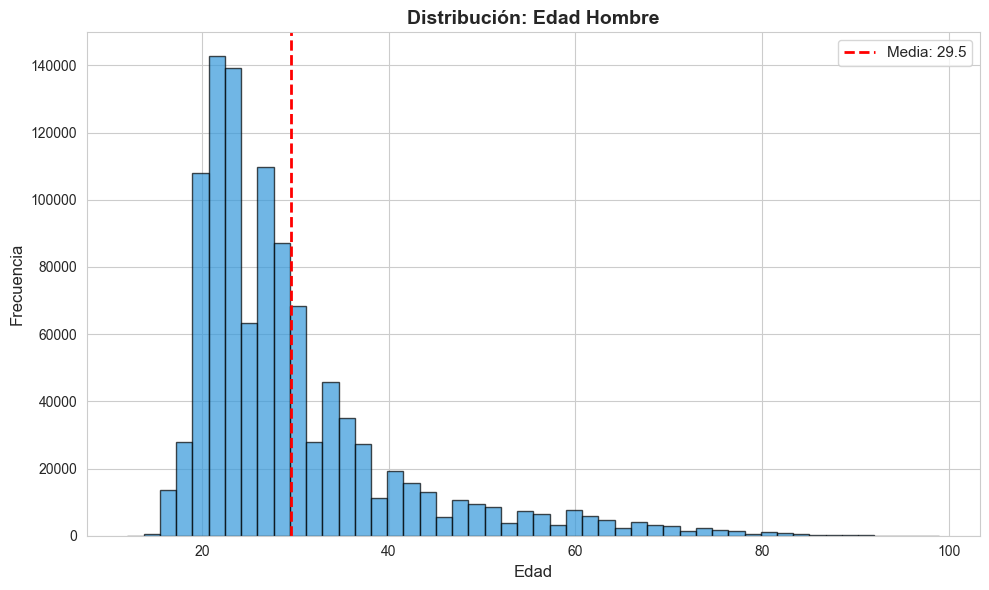

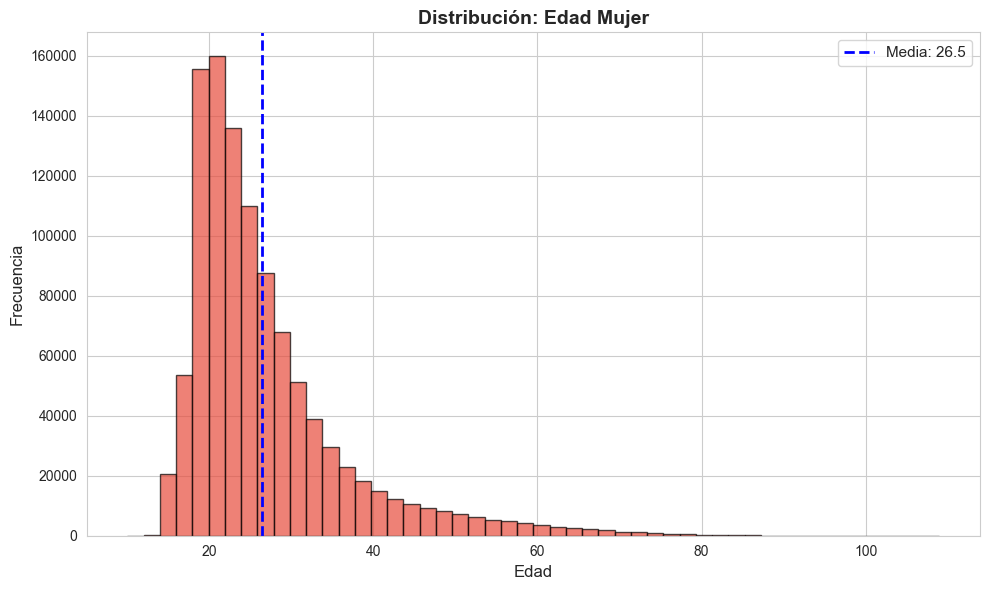

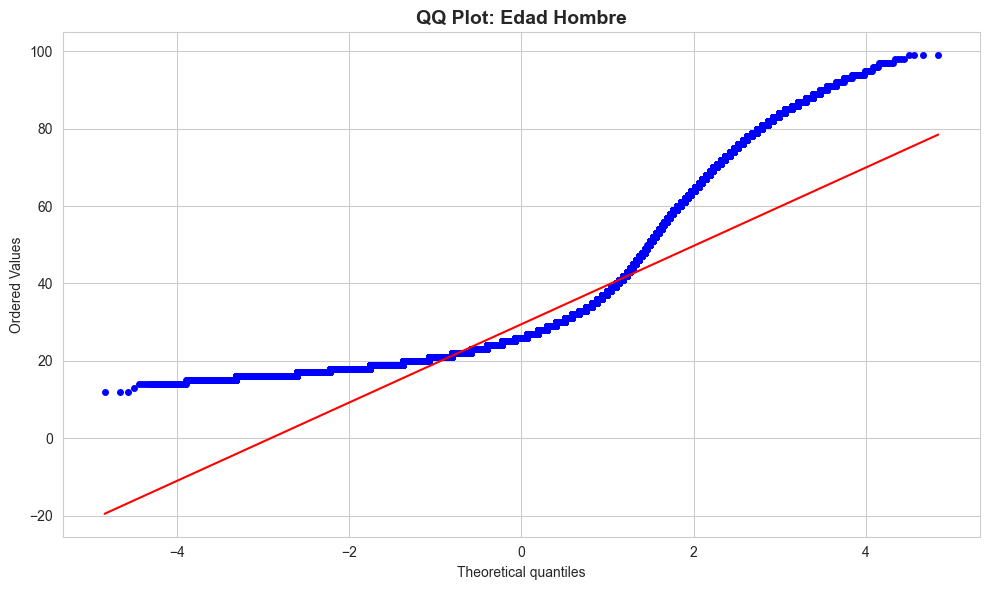

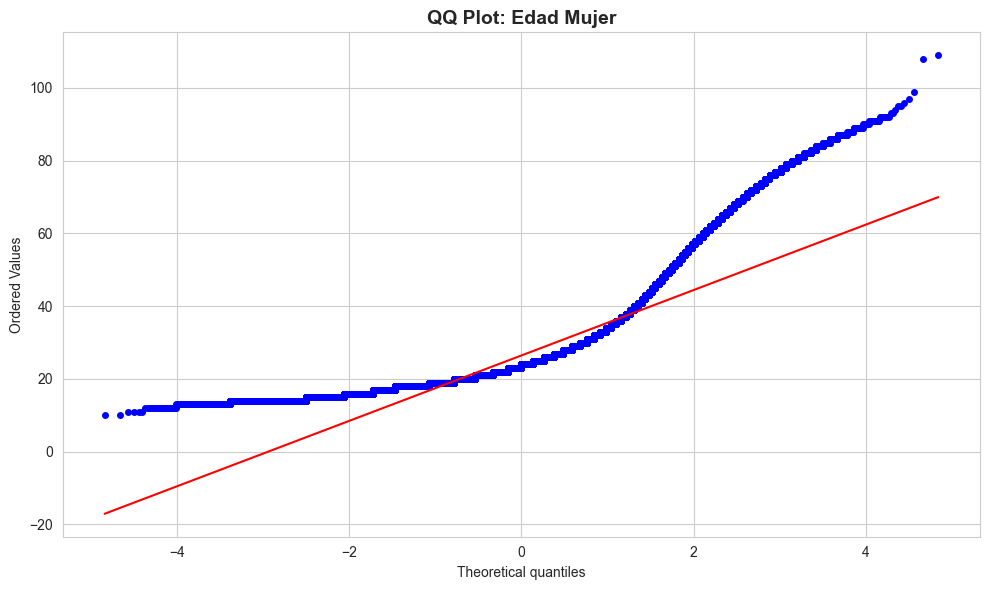

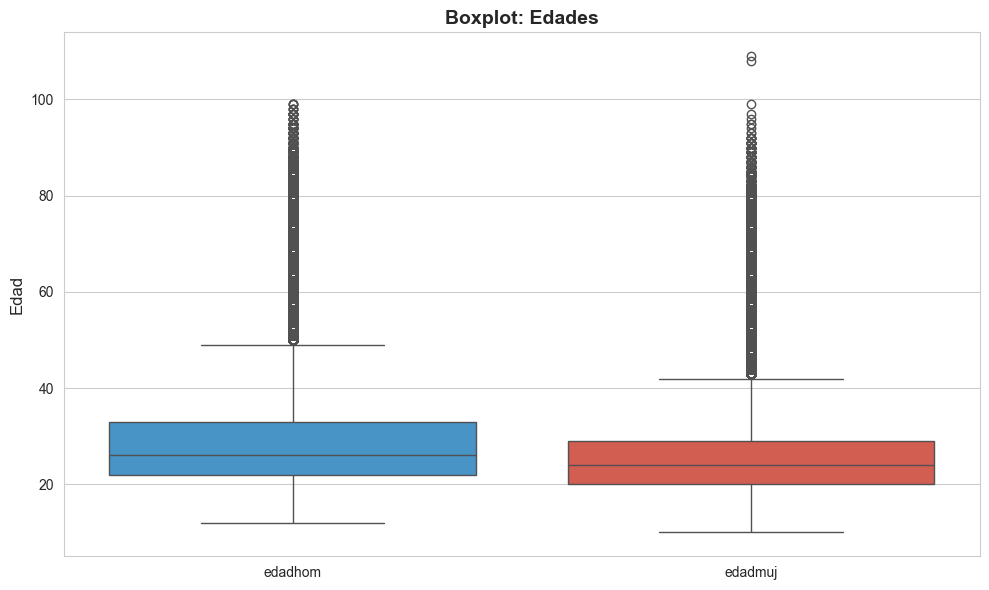

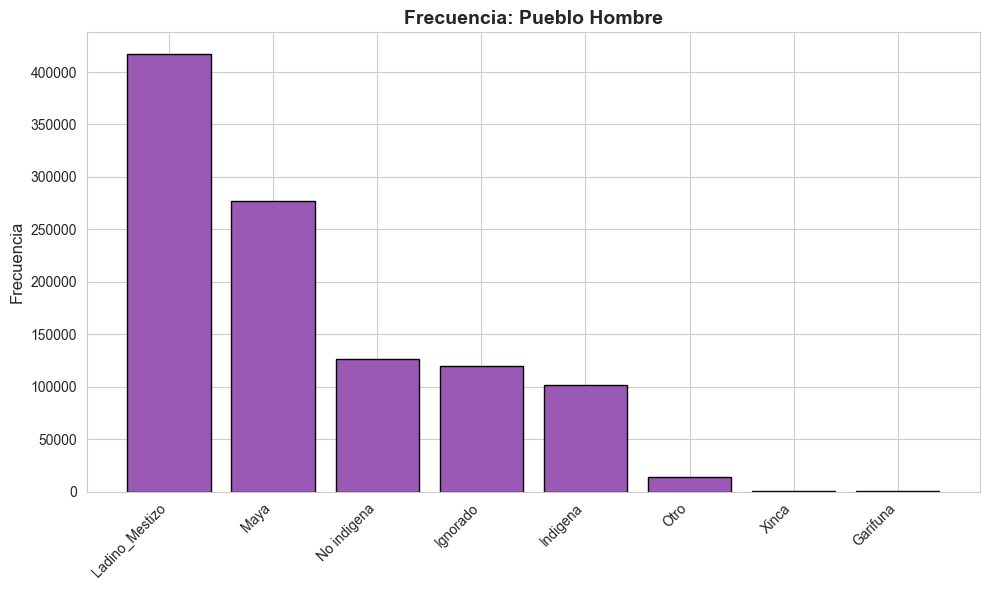

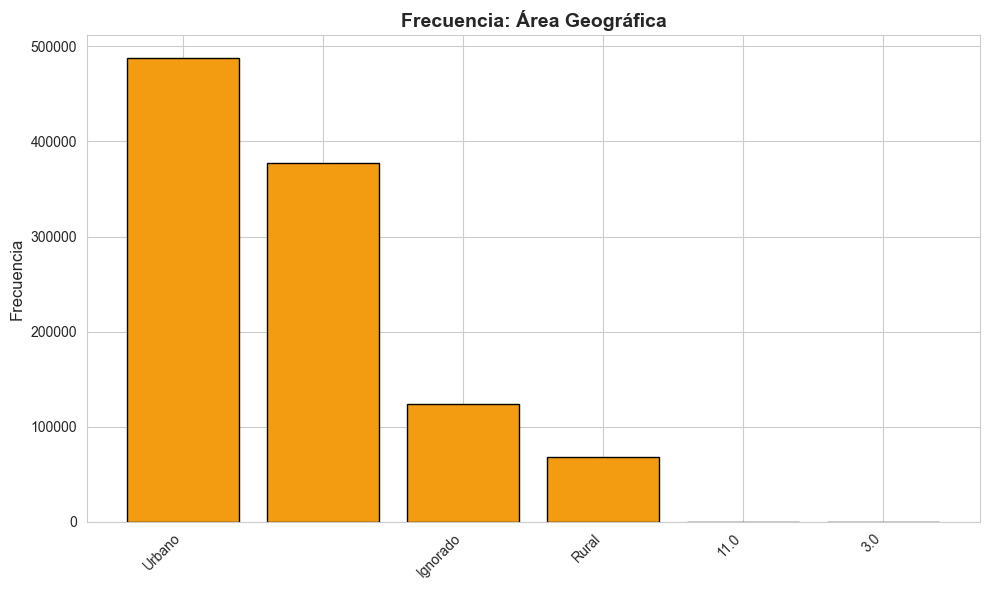

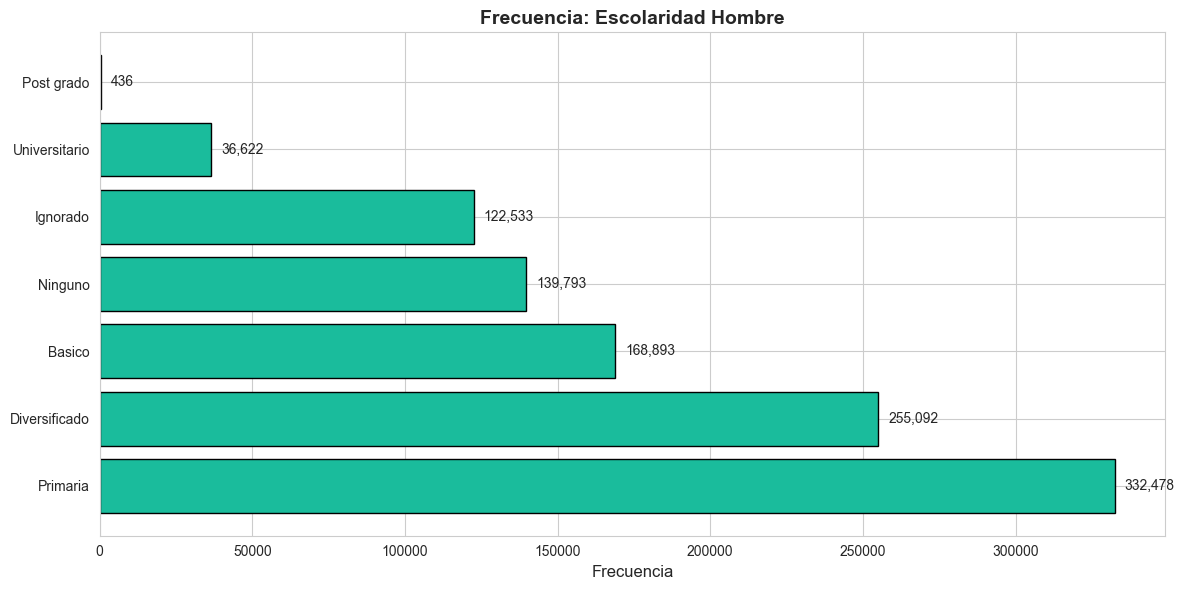

✓ Todas las imágenes guardadas en img/analysis/


In [16]:
plt.figure(figsize=(10, 6))
df_clean['edadhom'].hist(bins=50, edgecolor='black', alpha=0.7, color='#3498db')
plt.title('Distribución: Edad Hombre', fontweight='bold', fontsize=14)
plt.xlabel('Edad', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.axvline(df_clean['edadhom'].mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {df_clean["edadhom"].mean():.1f}')
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig('img/analysis/b1_dist_edad_hombre.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 6))
df_clean['edadmuj'].hist(bins=50, edgecolor='black', alpha=0.7, color='#e74c3c')
plt.title('Distribución: Edad Mujer', fontweight='bold', fontsize=14)
plt.xlabel('Edad', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.axvline(df_clean['edadmuj'].mean(), color='blue', linestyle='--', linewidth=2, label=f'Media: {df_clean["edadmuj"].mean():.1f}')
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig('img/analysis/b2_dist_edad_mujer.png', dpi=300, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
stats.probplot(df_clean['edadhom'].dropna(), dist="norm", plot=ax)
ax.set_title('QQ Plot: Edad Hombre', fontweight='bold', fontsize=14)
ax.get_lines()[0].set_markersize(4)
plt.tight_layout()
plt.savefig('img/analysis/b4_qq_edad_hombre.png', dpi=300, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
stats.probplot(df_clean['edadmuj'].dropna(), dist="norm", plot=ax)
ax.set_title('QQ Plot: Edad Mujer', fontweight='bold', fontsize=14)
ax.get_lines()[0].set_markersize(4)
plt.tight_layout()
plt.savefig('img/analysis/b5_qq_edad_mujer.png', dpi=300, bbox_inches='tight')
plt.show()


plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean[['edadhom', 'edadmuj']], palette=['#3498db', '#e74c3c'])
plt.title('Boxplot: Edades', fontweight='bold', fontsize=14)
plt.ylabel('Edad', fontsize=12)
plt.tight_layout()
plt.savefig('img/analysis/b7_boxplot_edades.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 6))
pueblo_hombre_counts = df_clean['pueblo_hombre'].value_counts()
plt.bar(pueblo_hombre_counts.index, pueblo_hombre_counts.values, color='#9b59b6', edgecolor='black')
plt.title('Frecuencia: Pueblo Hombre', fontweight='bold', fontsize=14)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('img/analysis/b8_freq_pueblo_hombre.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 6))
area_counts = df_clean['area_geografica'].value_counts()
plt.bar(area_counts.index, area_counts.values, color='#f39c12', edgecolor='black')
plt.title('Frecuencia: Área Geográfica', fontweight='bold', fontsize=14)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('img/analysis/b9_freq_area_geografica.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 6))
eschom_counts = df_clean['eschom'].value_counts()
plt.barh(eschom_counts.index, eschom_counts.values, color='#1abc9c', edgecolor='black')
plt.title('Frecuencia: Escolaridad Hombre', fontweight='bold', fontsize=14)
plt.xlabel('Frecuencia', fontsize=12)
for i, v in enumerate(eschom_counts.values):
    plt.text(v + max(eschom_counts.values)*0.01, i, f'{v:,}', va='center', fontsize=10)
plt.tight_layout()
plt.savefig('img/analysis/b10_freq_escolaridad_hombre.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Todas las imágenes guardadas en img/analysis/")

In [17]:
print("\n" + "="*50)
print("PREGUNTA C: Cruce de Variables Importantes")
print("="*50)

df_clean_filtered = df_clean[(df_clean['edadhom'] >= 15) & (df_clean['edadhom'] <= 80) & 
                              (df_clean['edadmuj'] >= 15) & (df_clean['edadmuj'] <= 80)].copy()

print(f"\nRegistros originales: {len(df_clean):,}")
print(f"Registros después de filtrar outliers de edad: {len(df_clean_filtered):,}")
print(f"Registros eliminados: {len(df_clean) - len(df_clean_filtered):,} ({(len(df_clean) - len(df_clean_filtered))/len(df_clean)*100:.2f}%)")

df_clean_filtered['edad_diferencia'] = df_clean_filtered['edadhom'] - df_clean_filtered['edadmuj']

educacion_map = {
    'Ninguno': 0,
    'Primaria': 1,
    'Basico': 2,
    'Diversificado': 3,
    'Universitario': 4,
    'Post grado': 5,
    'Ignorado': np.nan
}

df_clean_filtered['nivel_esc_hom'] = df_clean_filtered['eschom'].map(educacion_map)
df_clean_filtered['nivel_esc_muj'] = df_clean_filtered['escmuj'].map(educacion_map)
df_clean_filtered['brecha_educativa'] = df_clean_filtered['nivel_esc_hom'] - df_clean_filtered['nivel_esc_muj']

print("\n--- 1. ANÁLISIS DE EDADES (DATOS FILTRADOS) ---")
print(f"Edad promedio hombre: {df_clean_filtered['edadhom'].mean():.2f} años")
print(f"Edad promedio mujer: {df_clean_filtered['edadmuj'].mean():.2f} años")
print(f"Diferencia promedio de edad: {df_clean_filtered['edad_diferencia'].mean():.2f} años")
print(f"Mediana diferencia de edad: {df_clean_filtered['edad_diferencia'].median():.2f} años")

print("\n--- 2. ESTACIONALIDAD DE MATRIMONIOS ---")
meses_orden = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 
               'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
matrimonios_por_mes = df_clean_filtered['mesocu'].value_counts().reindex(meses_orden, fill_value=0)
print("\nMatrimonios por mes (ocurrencia):")
print(matrimonios_por_mes)
print(f"\nMes con más matrimonios: {matrimonios_por_mes.idxmax()} ({matrimonios_por_mes.max():,})")
print(f"Mes con menos matrimonios: {matrimonios_por_mes.idxmin()} ({matrimonios_por_mes.min():,})")
print(f"Variación: {((matrimonios_por_mes.max() - matrimonios_por_mes.min()) / matrimonios_por_mes.mean() * 100):.2f}%")

print("\n--- 3. TENDENCIA POR AÑO ---")
df_clean_filtered['año_ocurrencia'] = pd.to_numeric(df_clean_filtered['year'], errors='coerce')
matrimonios_por_año = df_clean_filtered['año_ocurrencia'].value_counts().sort_index()
print("\nMatrimonios por año:")
print(matrimonios_por_año)
años_validos = matrimonios_por_año[matrimonios_por_año.index.notna()].sort_index()
if len(años_validos) >= 2:
    primer_año = años_validos.index[0]
    ultimo_año = años_validos.index[-1]
    print(f"\nPrimer año: {int(primer_año)} ({años_validos.iloc[0]:,} matrimonios)")
    print(f"Último año: {int(ultimo_año)} ({años_validos.iloc[-1]:,} matrimonios)")
    cambio_pct = ((años_validos.iloc[-1] - años_validos.iloc[0]) / años_validos.iloc[0] * 100)
    print(f"Cambio total: {cambio_pct:+.2f}%")
    print(f"Año con más matrimonios: {int(años_validos.idxmax())} ({años_validos.max():,})")
    print(f"Año con menos matrimonios: {int(años_validos.idxmin())} ({años_validos.min():,})")

print("\n--- 4. BRECHA EDUCATIVA EN PAREJAS ---")
brecha_valida = df_clean_filtered['brecha_educativa'].dropna()
print(f"Media de brecha educativa: {brecha_valida.mean():.3f}")
print(f"Mediana de brecha educativa: {brecha_valida.median():.3f}")
print(f"\nDistribución de brecha:")
print(f"Hombre más educado (>0): {(brecha_valida > 0).sum():,} ({(brecha_valida > 0).sum()/len(brecha_valida)*100:.2f}%)")
print(f"Igual nivel educativo (=0): {(brecha_valida == 0).sum():,} ({(brecha_valida == 0).sum()/len(brecha_valida)*100:.2f}%)")
print(f"Mujer más educada (<0): {(brecha_valida < 0).sum():,} ({(brecha_valida < 0).sum()/len(brecha_valida)*100:.2f}%)")

print("\n--- 5. ESCOLARIDAD POR ÁREA GEOGRÁFICA ---")
escolaridad_por_area = pd.crosstab(df_clean_filtered['area_geografica'], 
                                    df_clean_filtered['eschom'], 
                                    normalize='index') * 100
print(escolaridad_por_area.round(2))

print("\n--- 6. HOMOGAMIA EDUCATIVA (Escolaridad H vs M) ---")
crosstab_esc = pd.crosstab(df_clean_filtered['eschom'], df_clean_filtered['escmuj'])
crosstab_esc_pct = pd.crosstab(df_clean_filtered['eschom'], df_clean_filtered['escmuj'], normalize='index') * 100
print("\nPorcentaje por fila:")
print(crosstab_esc_pct.round(2))

print("\n--- 7. HOMOGAMIA ÉTNICA (Pueblo H vs M) ---")
crosstab_pueblo = pd.crosstab(df_clean_filtered['pueblo_hombre'], df_clean_filtered['pueblo_mujer'])
crosstab_pueblo_pct = pd.crosstab(df_clean_filtered['pueblo_hombre'], df_clean_filtered['pueblo_mujer'], normalize='index') * 100
print("\nPorcentaje por fila:")
print(crosstab_pueblo_pct.round(2))

print("\n--- 8. TOP 10 DEPARTAMENTOS DE OCURRENCIA ---")
top_deptos = df_clean_filtered['depocu'].value_counts().head(10)
print(top_deptos)

print("\n--- 9. EDAD PROMEDIO POR ESCOLARIDAD ---")
edad_por_escolaridad = df_clean_filtered.groupby('eschom')[['edadhom', 'edadmuj']].mean().round(2)
print(edad_por_escolaridad)


PREGUNTA C: Cruce de Variables Importantes

Registros originales: 1,055,847
Registros después de filtrar outliers de edad: 1,041,697
Registros eliminados: 14,150 (1.34%)

--- 1. ANÁLISIS DE EDADES (DATOS FILTRADOS) ---
Edad promedio hombre: 29.38 años
Edad promedio mujer: 26.43 años
Diferencia promedio de edad: 2.96 años
Mediana diferencia de edad: 2.00 años

--- 2. ESTACIONALIDAD DE MATRIMONIOS ---

Matrimonios por mes (ocurrencia):
mesocu
Enero          81921
Febrero        90140
Marzo          94590
Abril          85223
Mayo           79004
Junio          71415
Julio          80571
Agosto         82788
Septiembre     70182
Octubre        87045
Noviembre     104904
Diciembre     113914
Name: count, dtype: int64

Mes con más matrimonios: Diciembre (113,914)
Mes con menos matrimonios: Septiembre (70,182)
Variación: 50.38%

--- 3. TENDENCIA POR AÑO ---

Matrimonios por año:
año_ocurrencia
2009.0    57519
2010.0    71669
2011.0    76807
2012.0    82723
2013.0    79421
2014.0    78355
20

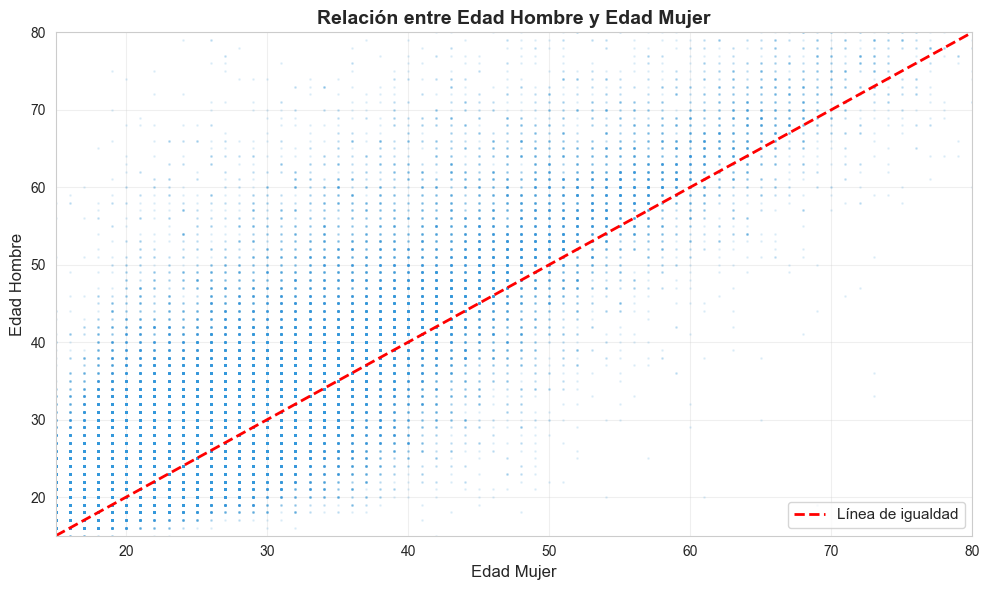

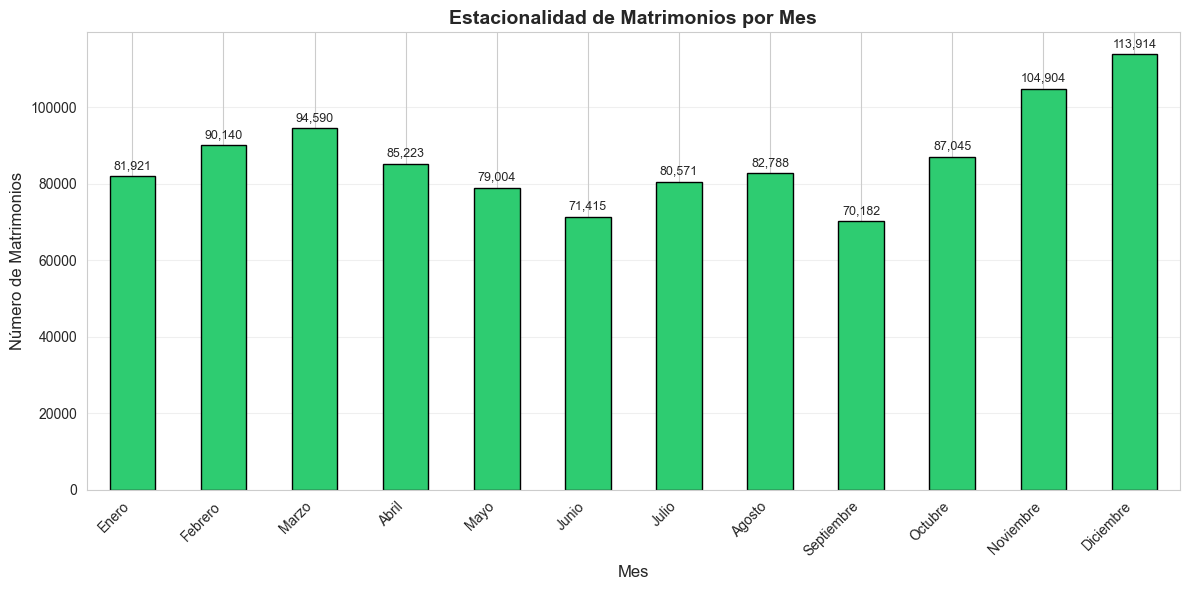

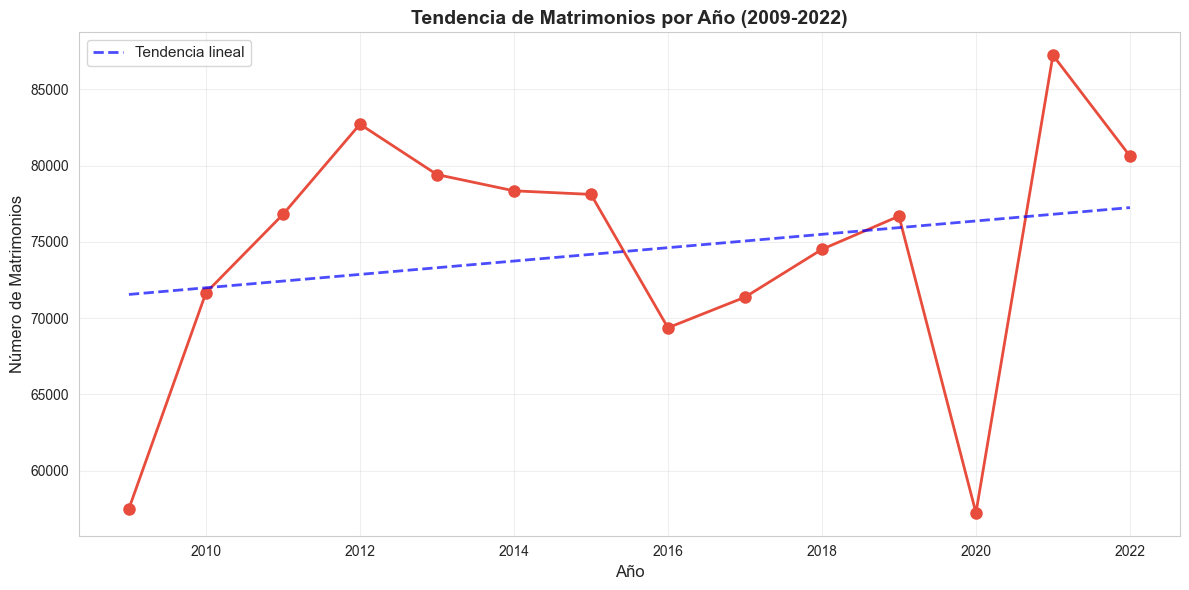

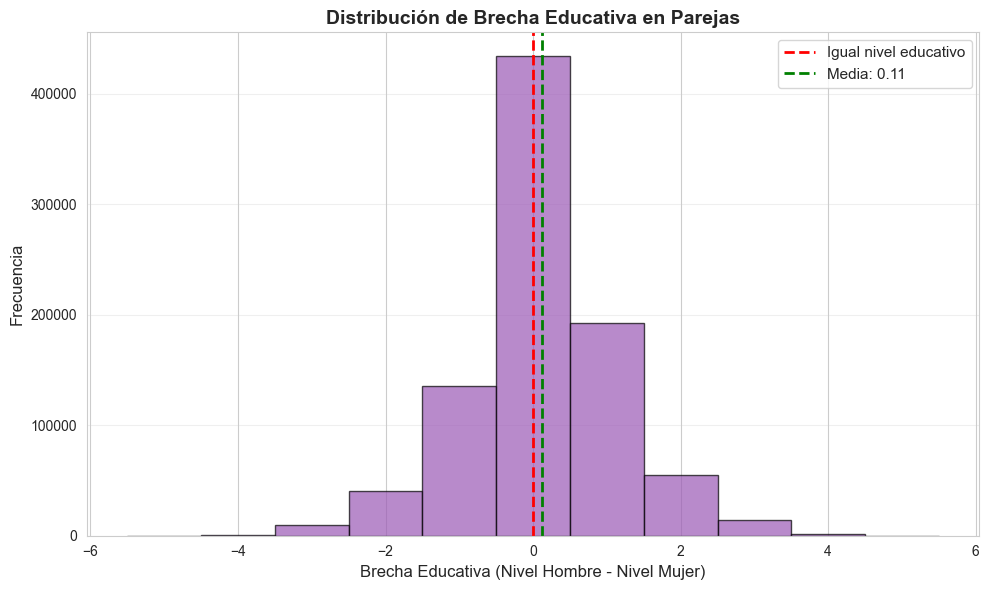

<Figure size 1000x600 with 0 Axes>

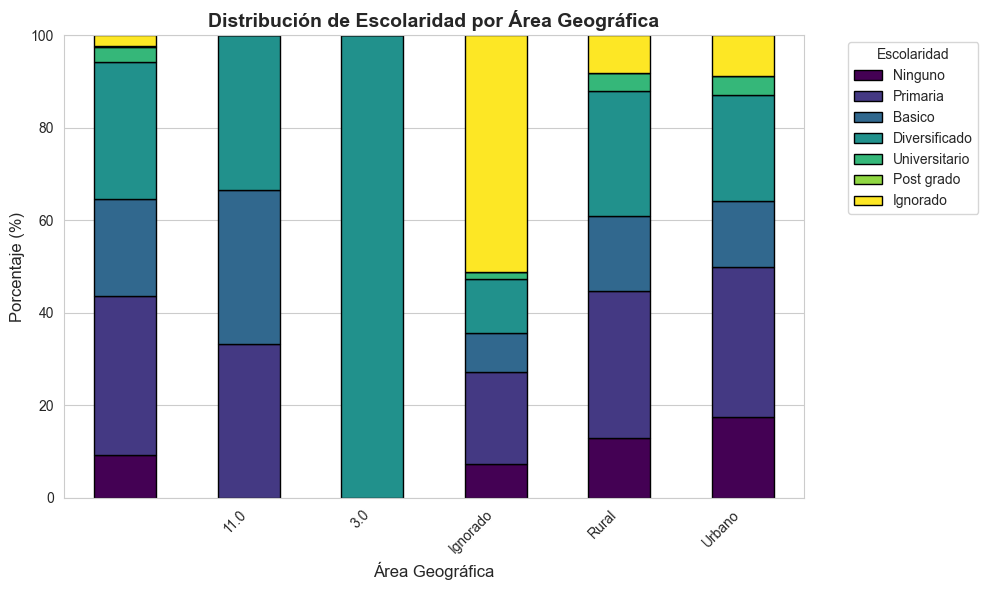

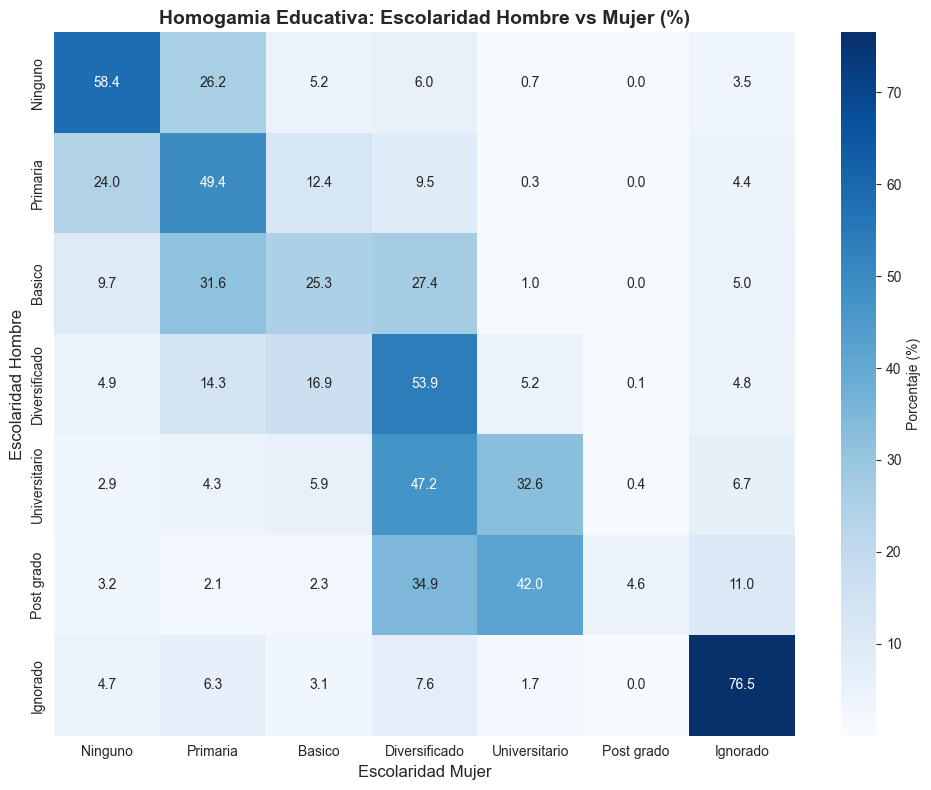

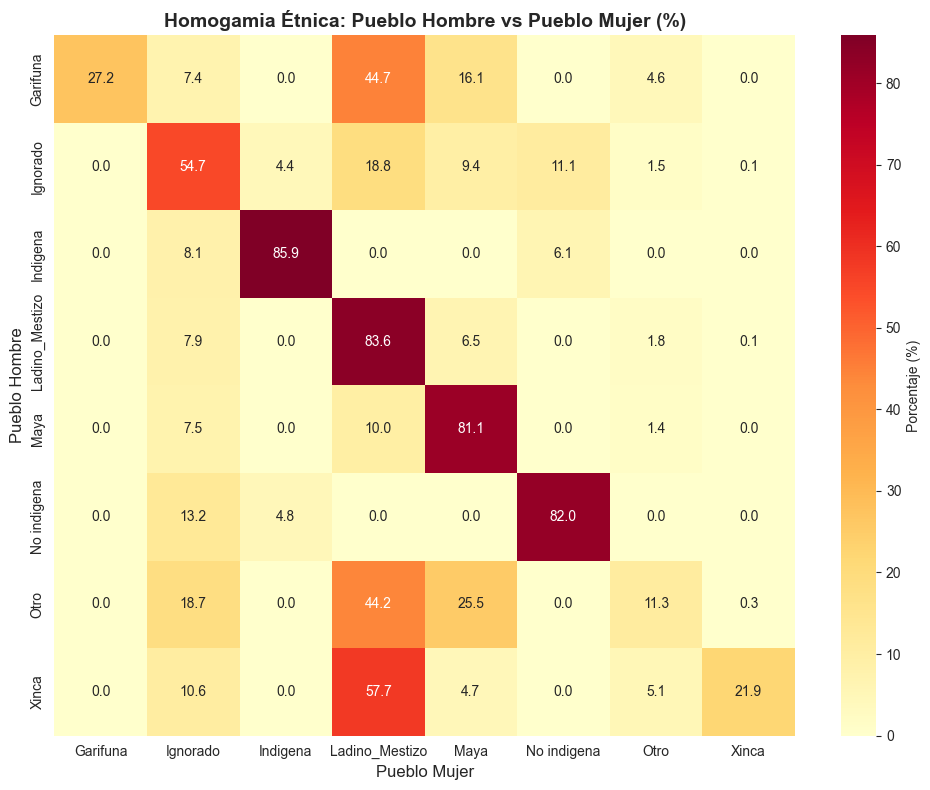

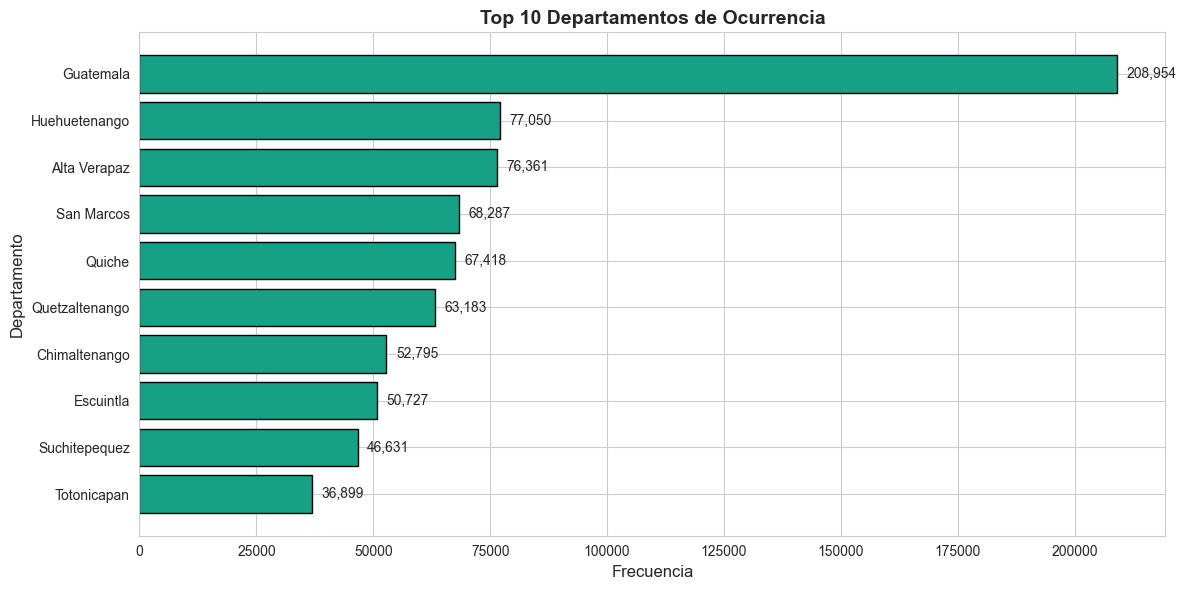

<Figure size 1200x600 with 0 Axes>

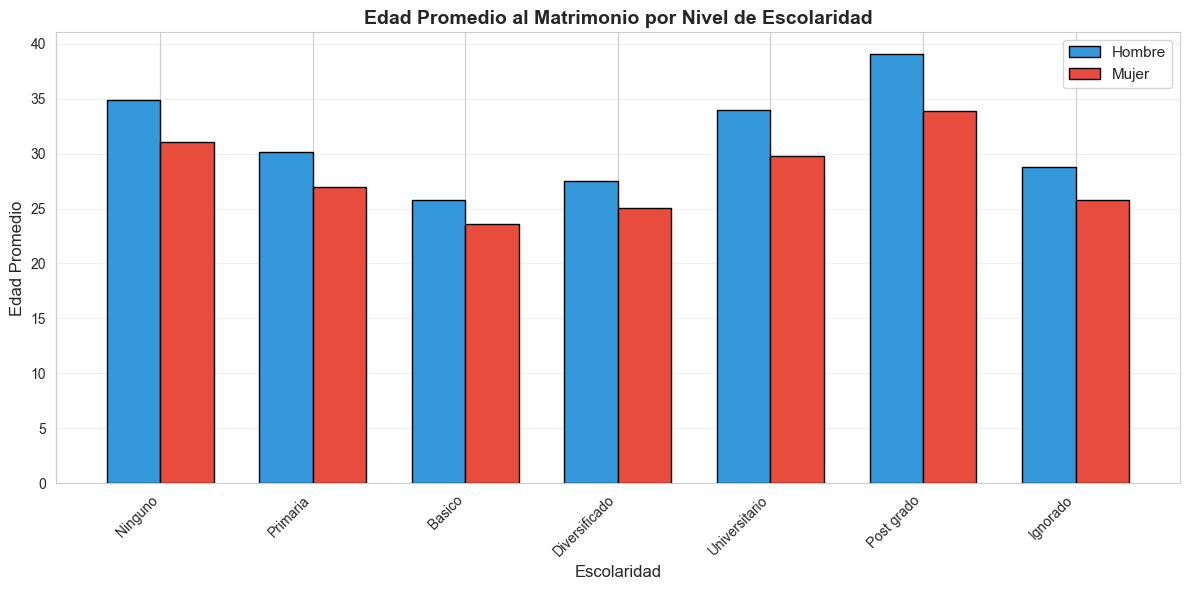

✓ Todas las imágenes de Pregunta C guardadas en img/analysis/


In [22]:
plt.figure(figsize=(10, 6))
sample_size = min(100000, len(df_clean_filtered))
df_sample = df_clean_filtered.sample(sample_size, random_state=42)
plt.scatter(df_sample['edadmuj'], df_sample['edadhom'], alpha=0.1, s=1, color='#3498db')
plt.plot([15, 80], [15, 80], 'r--', linewidth=2, label='Línea de igualdad')
plt.xlabel('Edad Mujer', fontsize=12)
plt.ylabel('Edad Hombre', fontsize=12)
plt.title('Relación entre Edad Hombre y Edad Mujer', fontweight='bold', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(15, 80)
plt.ylim(15, 80)
plt.tight_layout()
plt.savefig('img/analysis/c1_scatter_edades.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 6))
matrimonios_por_mes.plot(kind='bar', color='#2ecc71', edgecolor='black')
plt.xlabel('Mes', fontsize=12)
plt.ylabel('Número de Matrimonios', fontsize=12)
plt.title('Estacionalidad de Matrimonios por Mes', fontweight='bold', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(matrimonios_por_mes.values):
    plt.text(i, v + max(matrimonios_por_mes.values)*0.01, f'{v:,}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.savefig('img/analysis/c2_estacionalidad_mes.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 6))
años_validos = matrimonios_por_año[matrimonios_por_año.index.notna()].sort_index()
plt.plot(años_validos.index, años_validos.values, marker='o', linewidth=2, markersize=8, color='#e74c3c')
plt.xlabel('Año', fontsize=12)
plt.ylabel('Número de Matrimonios', fontsize=12)
plt.title('Tendencia de Matrimonios por Año (2009-2022)', fontweight='bold', fontsize=14)
plt.grid(True, alpha=0.3)
z = np.polyfit(años_validos.index, años_validos.values, 1)
p = np.poly1d(z)
plt.plot(años_validos.index, p(años_validos.index), "--", color='blue', alpha=0.7, linewidth=2, label='Tendencia lineal')
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig('img/analysis/c3_tendencia_año.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 6))
brecha_valida = df_clean_filtered['brecha_educativa'].dropna()
plt.hist(brecha_valida, bins=11, range=(-5.5, 5.5), edgecolor='black', alpha=0.7, color='#9b59b6')
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Igual nivel educativo')
plt.axvline(brecha_valida.mean(), color='green', linestyle='--', linewidth=2, label=f'Media: {brecha_valida.mean():.2f}')
plt.xlabel('Brecha Educativa (Nivel Hombre - Nivel Mujer)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Distribución de Brecha Educativa en Parejas', fontweight='bold', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('img/analysis/c4_brecha_educativa.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 6))
escolaridad_orden = ['Ninguno', 'Primaria', 'Basico', 'Diversificado', 'Universitario', 'Post grado', 'Ignorado']
escolaridad_por_area_ordered = pd.crosstab(df_clean_filtered['area_geografica'], 
                                            df_clean_filtered['eschom'], 
                                            normalize='index')[escolaridad_orden] * 100
escolaridad_por_area_ordered.plot(kind='bar', stacked=True, figsize=(10, 6), 
                                  colormap='viridis', edgecolor='black')
plt.xlabel('Área Geográfica', fontsize=12)
plt.ylabel('Porcentaje (%)', fontsize=12)
plt.title('Distribución de Escolaridad por Área Geográfica', fontweight='bold', fontsize=14)
plt.legend(title='Escolaridad', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('img/analysis/c5_escolaridad_por_area.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 8))
crosstab_esc_pct_ordered = pd.crosstab(df_clean_filtered['eschom'], df_clean_filtered['escmuj'], normalize='index')[escolaridad_orden].reindex(escolaridad_orden) * 100
sns.heatmap(crosstab_esc_pct_ordered, annot=True, fmt='.1f', cmap='Blues', cbar_kws={'label': 'Porcentaje (%)'})
plt.xlabel('Escolaridad Mujer', fontsize=12)
plt.ylabel('Escolaridad Hombre', fontsize=12)
plt.title('Homogamia Educativa: Escolaridad Hombre vs Mujer (%)', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('img/analysis/c6_heatmap_escolaridad.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 8))
crosstab_pueblo_norm = pd.crosstab(df_clean_filtered['pueblo_hombre'], df_clean_filtered['pueblo_mujer'], normalize='index') * 100
sns.heatmap(crosstab_pueblo_norm, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'Porcentaje (%)'})
plt.xlabel('Pueblo Mujer', fontsize=12)
plt.ylabel('Pueblo Hombre', fontsize=12)
plt.title('Homogamia Étnica: Pueblo Hombre vs Pueblo Mujer (%)', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('img/analysis/c7_crosstab_pueblo.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 6))
top_deptos = df_clean_filtered['depocu'].value_counts().head(10)
plt.barh(range(len(top_deptos)), top_deptos.values, color='#16a085', edgecolor='black')
plt.yticks(range(len(top_deptos)), top_deptos.index)
plt.xlabel('Frecuencia', fontsize=12)
plt.ylabel('Departamento', fontsize=12)
plt.title('Top 10 Departamentos de Ocurrencia', fontweight='bold', fontsize=14)
for i, v in enumerate(top_deptos.values):
    plt.text(v + max(top_deptos.values)*0.01, i, f'{v:,}', va='center', fontsize=10)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('img/analysis/c8_top_departamentos.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 6))
edad_por_esc_ordered = df_clean_filtered.groupby('eschom')[['edadhom', 'edadmuj']].mean().reindex(escolaridad_orden)
x = np.arange(len(edad_por_esc_ordered))
width = 0.35
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, edad_por_esc_ordered['edadhom'], width, label='Hombre', color='#3498db', edgecolor='black')
bars2 = ax.bar(x + width/2, edad_por_esc_ordered['edadmuj'], width, label='Mujer', color='#e74c3c', edgecolor='black')
ax.set_xlabel('Escolaridad', fontsize=12)
ax.set_ylabel('Edad Promedio', fontsize=12)
ax.set_title('Edad Promedio al Matrimonio por Nivel de Escolaridad', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(edad_por_esc_ordered.index, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('img/analysis/c9_edad_por_escolaridad.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Todas las imágenes de Pregunta C guardadas en img/analysis/")